Source: https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch

In [1]:
!pip install kaggle

In [2]:
import os
from pathlib import Path

competition = "titanic"  # Change this to any Kaggle competition name
iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")

if iskaggle:
    path = Path(f"../input/{competition}")
else:
    import kaggle

    # Use .kaggle_data folders that will be gitignored
    path = Path(".kaggle_data")

    if not path.exists():
        import zipfile

        kaggle.api.competition_download_cli(competition=competition, path=str(path))
        zipfile.ZipFile(f"{path}/{competition}.zip").extractall(path)

print(f"Ready for competition: {competition}")

Ready for competition: titanic


In [3]:
import numpy as np
import pandas as pd
import torch

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

In [4]:
df = pd.read_csv(path / "train.csv")
df

PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket  \
0              1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   
1              2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599   
2              3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   
3              4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803   
4              5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   
..           ...       ...     ...                                                ...     ...   ...    ...    ...               ...   
886          887         0       2                              Montvila, Rev. Juozas    male  27.0      0      0            211536   
887          888         1       1                       Graham, Miss. Margaret Edith  female  19.0      0      0            112053   
888          889         0       3           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1      2        W./C. 6607   
889          890         1       1                              Behr, Mr. Karl Howell    male  26.0      0      0            111369   
890          891         0       3                                Dooley, Mr. Patrick    male  32.0      0      0            370376   

        Fare Cabin Embarked  
0     7.2500   NaN        S  
1    71.2833   C85        C  
2     7.9250   NaN        S  
3    53.1000  C123        S  
4     8.0500   NaN        S  
..       ...   ...      ...  
886  13.0000   NaN        S  
887  30.0000   B42        S  
888  23.4500   NaN        S  
889  30.0000  C148        C  
890   7.7500   NaN        Q  

[891 rows x 12 columns]

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True)

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe(include=(np.number))

PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   28.566970    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   13.199572    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   24.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [10]:
df.describe(include=object)

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      891      891
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7      691      646

Fontconfig warning: ignoring UTF-8: not a valid region tag


<AxesSubplot: >

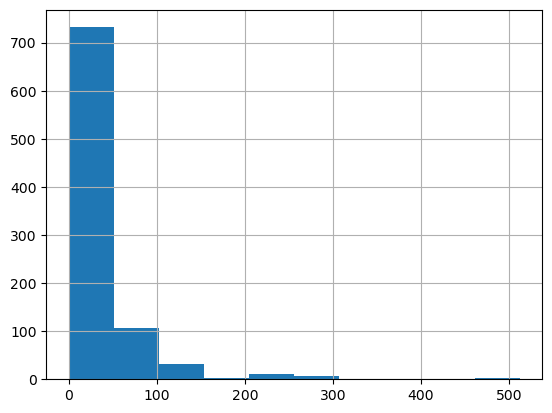

In [17]:
df["Fare"].hist()

In [18]:
df["LogFare"] = np.log(df["Fare"] + 1)

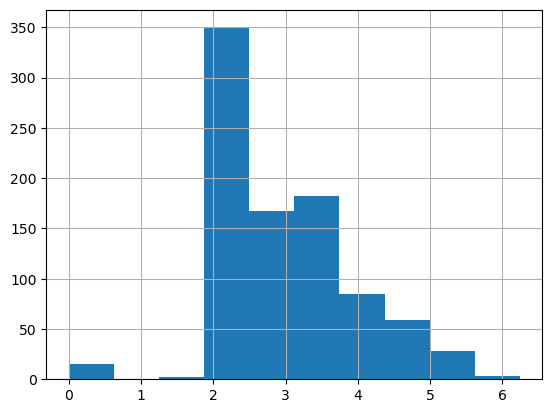

In [19]:
df["LogFare"].hist()

In [20]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [24]:
df.describe(include=[object])

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      891      891
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7      691      646

In [25]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [26]:
added_cols = [
    "Sex_male",
    "Sex_female",
    "Pclass_1",
    "Pclass_2",
    "Pclass_3",
    "Embarked_C",
    "Embarked_Q",
    "Embarked_S",
]
df[added_cols].head()

Sex_male  Sex_female  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  Embarked_S
0         1           0         0         0         1           0           0           1
1         0           1         1         0         0           1           0           0
2         0           1         0         0         1           0           0           1
3         0           1         1         0         0           0           0           1
4         1           0         0         0         1           0           0           1

In [27]:
from torch import tensor

t_dep = tensor(df.Survived)

In [28]:
indep_cols = ["Age", "SibSp", "Parch", "LogFare"] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [29]:
t_indep.shape

torch.Size([891, 12])

In [30]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [34]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [35]:
vals, indices = t_indep.max(dim=0)

# broadcasting
t_indep = t_indep / vals

In [36]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [37]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234